In [1]:
# pip install nes-py

In [2]:
# pip install gym-super-mario-bros

# 程式 8.1： 建立瑪利歐遊戲環境

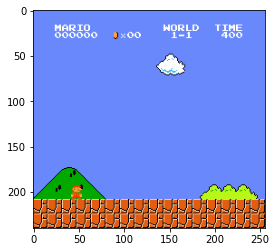

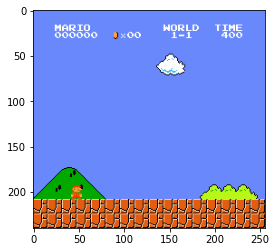

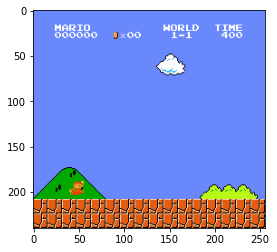

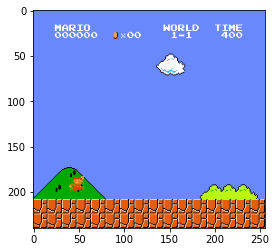

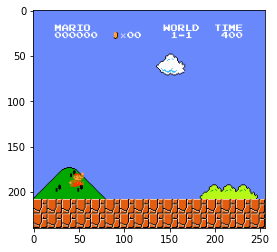

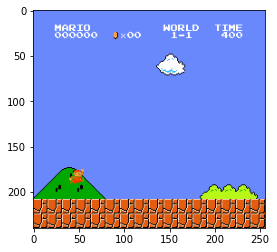

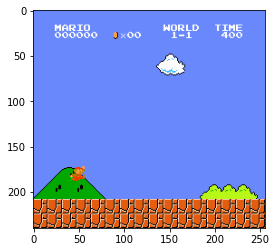

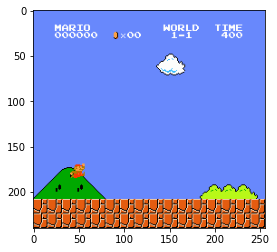

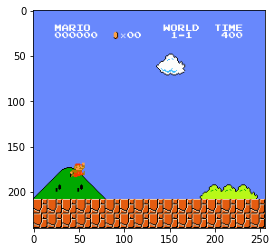

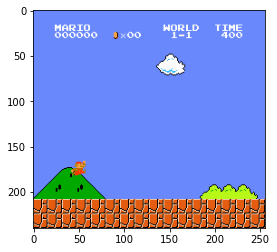

In [3]:
import gym
from nes_py.wrappers import JoypadSpace #此wrapper模組透過結合不同動作來縮小動作空間
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #我們可以匯入的動作空間共有兩種：一種只包含5個動作（simple），另一種則包含12個動作（complex）
import matplotlib.pyplot as plt
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #選擇complex的動作空間（有12個離散動作）
done = True
for step in range(10): 
  if done:
    state = env.reset() #如果遊戲結束，就重置環境
  state, reward, done, info = env.step(env.action_space.sample())#從動作空間中，隨機選擇動作來執行
  plt.imshow(env.render('rgb_array'))
  plt.pause(0.05)


# 程式 8.2: 將狀態資料轉成灰階並進行downsampling

In [4]:
import matplotlib.pyplot as plt
from skimage.transform import resize #該函式庫中內建可調整畫面shape的函式
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):
  if to_gray:
    return resize(obs, new_size, anti_aliasing=True).max(axis=2) #為了將圖片轉換成灰階，我們取出obs第二階（顏色通道）中的最大值
  else:
    return resize(obs, new_size, anti_aliasing=True)

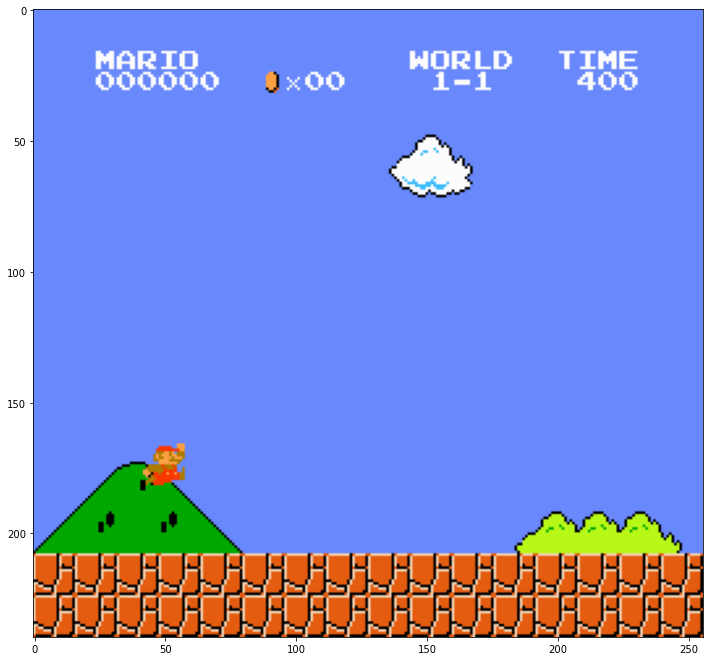

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(env.render("rgb_array")) #呈現原始遊戲畫面

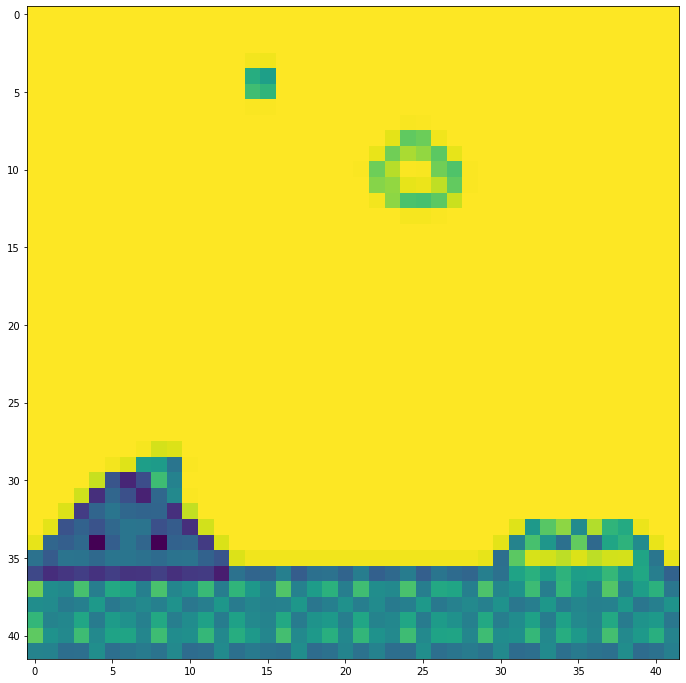

In [6]:
plt.figure(figsize=(12,12))
plt.imshow(downscale_obs(env.render("rgb_array"))) #呈現經過處理的遊戲畫面

# 程式 8.3： 準備狀態資料

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state): 
  return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2): #更新最近的3個遊戲畫面。state1是包含3個遊戲畫面的狀態資料；state2則是最近的遊戲畫面
  state1 = state1.clone()
  tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float() #調整state2的shape
  state1[0][0] = state1[0][1]  #更新state1的3個遊戲畫面,最舊的畫面被淘汰，加入最新的遊戲畫面
  state1[0][1] = state1[0][2]
  state1[0][2] = tmp
  return state1

def prepare_initial_state(state,N=3): 
  state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
  tmp = state_.repeat((N,1,1)) #將初始遊戲畫面複製三份
  return tmp.unsqueeze(dim=0) #在第0階的位置加入批次維度

# 程式 8.4： 策略函數

In [8]:
def policy(qvalues, eps=None): #策略函數接受動作價值向量與ε參數（eps）
  if eps is not None: #若有指定一個eps值，則使用ε—貪婪策略
    if torch.rand(1) < eps:
      return torch.randint(low=0,high=11,size=(1,)) #從12個動作中隨機選取一個來執行
    else:
      return torch.argmax(qvalues)
  else: #若未指定eps值，則使用softmax策略
    return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #選擇一個要執行的動作

# 程式 8.5： 經驗回放

In [9]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
  def __init__(self, N=500, batch_size=100):
    self.N = N #N為記憶串列的最大長度
    self.batch_size = batch_size #訓練批次的長度
    self.memory = [] 
    self.counter = 0
      
  def add_memory(self, state1, action, reward, state2):
    self.counter +=1 
    if self.counter % 500 == 0: #記憶串列每新增500筆資料，便對記憶串列的內容進行洗牌，以更隨機的方式選取訓練批次
      self.shuffle_memory()         
    if len(self.memory) < self.N: #若記憶串列未滿，則將資料新增到串列中，否則隨機將串列中的一筆資料替換為新資料
      self.memory.append( (state1, action, reward, state2) )
    else:
      rand_index = np.random.randint(0,self.N-1)#隨機產生串列中要被替換掉的經驗索引
      self.memory[rand_index] = (state1, action, reward, state2)
  
  def shuffle_memory(self): #使用Python內建的shuffle函式來對記憶串列的內容進行洗牌
    shuffle(self.memory)
      
  def get_batch(self): #從記憶串列中隨機選取資料出來組成小批次
    if len(self.memory) < self.batch_size:
      batch_size = len(self.memory)
    else:
      batch_size = self.batch_size
    if len(self.memory) < 1:
      print("Error: No data in memory.")
      return None        
    ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False) #隨機選出要組成訓練批次的經驗索引
    batch = [self.memory[i] for i in ind] 
    state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
    action_batch = torch.Tensor([x[1] for x in batch]).long()
    reward_batch = torch.Tensor([x[2] for x in batch])
    state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
    return state1_batch, action_batch, reward_batch, state2_batch

# 程式 8.6： 建構ICM中的各模型

In [10]:
class Phi(nn.Module): #Phi代表編碼器網路
  def __init__(self):
    super(Phi, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

  def forward(self,x):
    x = F.normalize(x)
    y = F.elu(self.conv1(x))
    y = F.elu(self.conv2(y))
    y = F.elu(self.conv3(y))
    y = F.elu(self.conv4(y)) #輸出的大小為 [1,32,3,3] 
    y = y.flatten(start_dim=1) #shape扁平化成N,288
    return y

class Gnet(nn.Module): #Gnet代表反向模型
  def __init__(self):
    super(Gnet, self).__init__()
    self.linear1 = nn.Linear(576,256)
    self.linear2 = nn.Linear(256,12)

  def forward(self, state1,state2):
    x = torch.cat( (state1, state2) ,dim=1)
    y = F.relu(self.linear1(x))
    y = self.linear2(y)
    y = F.softmax(y,dim=1)
    return y

class Fnet(nn.Module): #Fnet代表正向模型
  def __init__(self):
    super(Fnet, self).__init__()
    self.linear1 = nn.Linear(300,256)
    self.linear2 = nn.Linear(256,288)

  def forward(self,state,action):
    action_ = torch.zeros(action.shape[0],12) #將執行的動作批次編碼成one-hot向量
    indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
    indices = indices.tolist()
    action_[indices] = 1.
    x = torch.cat( (state,action_) ,dim=1)
    y = F.relu(self.linear1(x))
    y = self.linear2(y)
    return y

# 程式 8.7： 定義DQN模型

In [11]:
class Qnetwork(nn.Module):
  def __init__(self):
    super(Qnetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
    self.linear1 = nn.Linear(288,100)
    self.linear2 = nn.Linear(100,12)
      
  def forward(self,x):
    x = F.normalize(x)
    y = F.elu(self.conv1(x))
    y = F.elu(self.conv2(y))
    y = F.elu(self.conv3(y))
    y = F.elu(self.conv4(y))
    y = y.flatten(start_dim=2)
    y = y.view(y.shape[0], -1, 32)
    y = y.flatten(start_dim=1)
    y = F.elu(self.linear1(y))
    y = self.linear2(y)
    return y

# 程式 8.8： 超參數與模型實例

In [12]:
params = {
    'batch_size':150, 
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0 ,
    'gamma':0.2,  
    'max_episode_len':100, 
    'min_progress':15, 
    'action_repeats':6,
    'frames_per_state':3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #我們將不同模型的參數加到同一串列中，再將該串列傳給單一優化器
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params) 

# 程式 8.9： 損失函數與重置環境函式

In [13]:
def loss_fn(q_loss, inverse_loss, forward_loss):
  loss_ = (1 - params['beta']) * inverse_loss
  loss_ += params['beta'] * forward_loss
  loss_ = loss_.sum() / loss_.flatten().shape[0]
  loss = loss_ + params['lambda'] * q_loss
  return loss

def reset_env():
  env.reset()
  state1 = prepare_initial_state(env.render('rgb_array'))
  return state1

# 程式 8.10： 計算ICM的預測誤差

In [14]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
  state1_hat = encoder(state1) #使用編碼器將狀態1和2（兩個連續狀態）編碼
  state2_hat = encoder(state2)
  state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) #利用正向模型預測新的狀態
  forward_pred_err = forward_scale * forward_loss(state2_hat_pred,state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
  pred_action = inverse_model(state1_hat, state2_hat) #反向模型傳回各動作的機率分佈
  inverse_pred_err = inverse_scale * inverse_loss(pred_action,action.detach().flatten()).unsqueeze(dim=1)
  return forward_pred_err, inverse_pred_err

# 程式 8.11： 使用經驗回放進行小批次訓練

In [15]:
def minibatch_train(use_extrinsic=True):
  state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
  action_batch = action_batch.view(action_batch.shape[0],1) #在此張量中增加一個維度，以符合模型的需求
  reward_batch = reward_batch.view(reward_batch.shape[0],1)  
  forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #運行ICM
  i_reward = (1. / params['eta']) * forward_pred_err #使用eta參數來調整預測誤差的權重
  reward = i_reward.detach() #把i_reward張量從運算圖中分離，並開始計算總回饋值
  if use_extrinsic: #決定演算法是否要使用外在回饋值
    reward += reward_batch 
  qvals = Qmodel(state2_batch) #計算新狀態的動作價值
  reward += params['gamma'] * torch.max(qvals)
  reward_pred = Qmodel(state1_batch)
  reward_target = reward_pred.clone()
  indices = torch.stack( (torch.arange(action_batch.shape[0]),action_batch.squeeze()), dim=0) #action_batch是由整數組成的張量，且每個整數代表一個動作的索引值，這裡將它們轉換成由多個one-hot編碼向量組成的張量。
  indices = indices.tolist()
  reward_target[indices] = reward.squeeze()
  q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
  return forward_pred_err, inverse_pred_err, q_loss

# 程式 8.12： 主要訓練迴圈

In [ ]:
from IPython.display import clear_output
epochs = 50000
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps=0.15
losses = []
episode_length = 0
switch_to_eps_greedy =1000 
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = env.env.env._x_position #用來追踪馬利歐是否有在前進，若很久沒前進則重置遊戲
ep_lengths = []
use_extrinsic = False #不使用外在回饋值
for i in range(epochs):
  print("Epochs:",i," Game progress:",last_x_pos)      
  #clear_output(wait=True)
  opt.zero_grad()
  episode_length += 1
  q_val_pred = Qmodel(state1) #運行DQN並預測一個動作價值向量
  if i > switch_to_eps_greedy: #在1,000次訓練過後，換成 ε—貪婪策略
    action = int(policy(q_val_pred,eps))
  else:
    action = int(policy(q_val_pred))
  for j in range(params['action_repeats']): #為加速學習，將選擇的動作重複6次
    state2, e_reward_, done, info = env.step(action)
    last_x_pos = info['x_pos']
    if done:
      state1 = reset_env()
      break
    e_reward += e_reward_
    state_deque.append(prepare_state(state2))
  state2 = torch.stack(list(state_deque),dim=1) #將state_deque串列轉換成張量
  replay.add_memory(state1, action, e_reward, state2) #將單一經驗資料存入經驗池
  e_reward = 0
  if episode_length > params['max_episode_len']: #若瑪利歐未在遊戲中前進足夠距離，則將遊戲重啟，再試一次
    if (info['x_pos'] - last_x_pos) < params['min_progress']:
      done = True
    else:
      last_x_pos = info['x_pos']
  if done:
    ep_lengths.append(info['x_pos'])
    state1 = reset_env()
    last_x_pos = env.env.env._x_position
    episode_length = 0
  else:
    state1 = state2
  if len(replay.memory) < params['batch_size']:
    continue
  forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False) #根據從經驗池選出的一小批次資料，計算各模型的誤差
  loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #計算整體損失
  loss_list = (q_loss.mean().to("cpu"), forward_pred_err.flatten().mean().to("cpu"), inverse_pred_err.flatten().mean().to("cpu"))
  losses.append(loss_list)
  loss.backward()
  opt.step()

Epochs: 0  Game progress: 40
Epochs: 1  Game progress: 38
Epochs: 2  Game progress: 37
Epochs: 3  Game progress: 37
Epochs: 4  Game progress: 39
Epochs: 5  Game progress: 45


C:\Users\20613\AppData\Local\Temp/ipykernel_14300/812776223.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #選擇一個要執行的動作


Epochs: 6  Game progress: 51
Epochs: 7  Game progress: 55
Epochs: 8  Game progress: 60
Epochs: 9  Game progress: 60
Epochs: 10  Game progress: 57
Epochs: 11  Game progress: 51
Epochs: 12  Game progress: 44
Epochs: 13  Game progress: 34
Epochs: 14  Game progress: 23
Epochs: 15  Game progress: 13
Epochs: 16  Game progress: 2
Epochs: 17  Game progress: 0
Epochs: 18  Game progress: 1
Epochs: 19  Game progress: 7
Epochs: 20  Game progress: 16
Epochs: 21  Game progress: 25
Epochs: 22  Game progress: 33
Epochs: 23  Game progress: 41
Epochs: 24  Game progress: 41
Epochs: 25  Game progress: 41
Epochs: 26  Game progress: 39
Epochs: 27  Game progress: 34
Epochs: 28  Game progress: 29
Epochs: 29  Game progress: 25
Epochs: 30  Game progress: 23
Epochs: 31  Game progress: 22
Epochs: 32  Game progress: 22
Epochs: 33  Game progress: 21
Epochs: 34  Game progress: 20
Epochs: 35  Game progress: 19
Epochs: 36  Game progress: 17
Epochs: 37  Game progress: 19
Epochs: 38  Game progress: 21
Epochs: 39  Game p

Epochs: 270  Game progress: 169
Epochs: 271  Game progress: 170
Epochs: 272  Game progress: 172
Epochs: 273  Game progress: 175
Epochs: 274  Game progress: 177
Epochs: 275  Game progress: 178
Epochs: 276  Game progress: 177
Epochs: 277  Game progress: 171
Epochs: 278  Game progress: 162
Epochs: 279  Game progress: 152
Epochs: 280  Game progress: 143
Epochs: 281  Game progress: 141
Epochs: 282  Game progress: 140
Epochs: 283  Game progress: 140
Epochs: 284  Game progress: 138
Epochs: 285  Game progress: 135
Epochs: 286  Game progress: 134
Epochs: 287  Game progress: 136
Epochs: 288  Game progress: 139
Epochs: 289  Game progress: 139
Epochs: 290  Game progress: 142
Epochs: 291  Game progress: 147
Epochs: 292  Game progress: 150
Epochs: 293  Game progress: 154
Epochs: 294  Game progress: 161
Epochs: 295  Game progress: 169
Epochs: 296  Game progress: 177
Epochs: 297  Game progress: 186
Epochs: 298  Game progress: 195
Epochs: 299  Game progress: 206
Epochs: 300  Game progress: 215
Epochs: 

Epochs: 533  Game progress: 218
Epochs: 534  Game progress: 213
Epochs: 535  Game progress: 207
Epochs: 536  Game progress: 198
Epochs: 537  Game progress: 189
Epochs: 538  Game progress: 187
Epochs: 539  Game progress: 191
Epochs: 540  Game progress: 197
Epochs: 541  Game progress: 201
Epochs: 542  Game progress: 206
Epochs: 543  Game progress: 211
Epochs: 544  Game progress: 214
Epochs: 545  Game progress: 213
Epochs: 546  Game progress: 209
Epochs: 547  Game progress: 203
Epochs: 548  Game progress: 196
Epochs: 549  Game progress: 188
Epochs: 550  Game progress: 181
Epochs: 551  Game progress: 172
Epochs: 552  Game progress: 163
Epochs: 553  Game progress: 160
Epochs: 554  Game progress: 158
Epochs: 555  Game progress: 154
Epochs: 556  Game progress: 148
Epochs: 557  Game progress: 139
Epochs: 558  Game progress: 135
Epochs: 559  Game progress: 135
Epochs: 560  Game progress: 135
Epochs: 561  Game progress: 135
Epochs: 562  Game progress: 135
Epochs: 563  Game progress: 136
Epochs: 

Epochs: 794  Game progress: 14
Epochs: 795  Game progress: 13
Epochs: 796  Game progress: 14
Epochs: 797  Game progress: 15
Epochs: 798  Game progress: 18
Epochs: 799  Game progress: 21
Epochs: 800  Game progress: 21
Epochs: 801  Game progress: 20
Epochs: 802  Game progress: 14
Epochs: 803  Game progress: 5
Epochs: 804  Game progress: 2
Epochs: 805  Game progress: 2
Epochs: 806  Game progress: 4
Epochs: 807  Game progress: 4
Epochs: 808  Game progress: 40
Epochs: 809  Game progress: 40
Epochs: 810  Game progress: 40
Epochs: 811  Game progress: 41
Epochs: 812  Game progress: 44
Epochs: 813  Game progress: 48
Epochs: 814  Game progress: 51
Epochs: 815  Game progress: 54
Epochs: 816  Game progress: 56
Epochs: 817  Game progress: 58
Epochs: 818  Game progress: 57
Epochs: 819  Game progress: 56
Epochs: 820  Game progress: 58
Epochs: 821  Game progress: 60
Epochs: 822  Game progress: 61
Epochs: 823  Game progress: 64
Epochs: 824  Game progress: 66
Epochs: 825  Game progress: 66
Epochs: 826  

Epochs: 1057  Game progress: 163
Epochs: 1058  Game progress: 157
Epochs: 1059  Game progress: 150
Epochs: 1060  Game progress: 148
Epochs: 1061  Game progress: 147
Epochs: 1062  Game progress: 142
Epochs: 1063  Game progress: 132
Epochs: 1064  Game progress: 120
Epochs: 1065  Game progress: 104
Epochs: 1066  Game progress: 86
Epochs: 1067  Game progress: 68
Epochs: 1068  Game progress: 53
Epochs: 1069  Game progress: 53
Epochs: 1070  Game progress: 53
Epochs: 1071  Game progress: 53
Epochs: 1072  Game progress: 53
Epochs: 1073  Game progress: 53
Epochs: 1074  Game progress: 53
Epochs: 1075  Game progress: 53
Epochs: 1076  Game progress: 54
Epochs: 1077  Game progress: 57
Epochs: 1078  Game progress: 57
Epochs: 1079  Game progress: 58
Epochs: 1080  Game progress: 56
Epochs: 1081  Game progress: 53
Epochs: 1082  Game progress: 53
Epochs: 1083  Game progress: 53
Epochs: 1084  Game progress: 53
Epochs: 1085  Game progress: 53
Epochs: 1086  Game progress: 53
Epochs: 1087  Game progress: 53

Epochs: 1312  Game progress: 210
Epochs: 1313  Game progress: 40
Epochs: 1314  Game progress: 40
Epochs: 1315  Game progress: 38
Epochs: 1316  Game progress: 37
Epochs: 1317  Game progress: 38
Epochs: 1318  Game progress: 43
Epochs: 1319  Game progress: 52
Epochs: 1320  Game progress: 63
Epochs: 1321  Game progress: 73
Epochs: 1322  Game progress: 82
Epochs: 1323  Game progress: 89
Epochs: 1324  Game progress: 99
Epochs: 1325  Game progress: 110
Epochs: 1326  Game progress: 120
Epochs: 1327  Game progress: 131
Epochs: 1328  Game progress: 141
Epochs: 1329  Game progress: 151
Epochs: 1330  Game progress: 158
Epochs: 1331  Game progress: 163
Epochs: 1332  Game progress: 166
Epochs: 1333  Game progress: 165
Epochs: 1334  Game progress: 162
Epochs: 1335  Game progress: 163
Epochs: 1336  Game progress: 165
Epochs: 1337  Game progress: 168
Epochs: 1338  Game progress: 172
Epochs: 1339  Game progress: 178
Epochs: 1340  Game progress: 187
Epochs: 1341  Game progress: 198
Epochs: 1342  Game pro

Epochs: 1567  Game progress: 26
Epochs: 1568  Game progress: 26
Epochs: 1569  Game progress: 27
Epochs: 1570  Game progress: 28
Epochs: 1571  Game progress: 28
Epochs: 1572  Game progress: 28
Epochs: 1573  Game progress: 29
Epochs: 1574  Game progress: 32
Epochs: 1575  Game progress: 37
Epochs: 1576  Game progress: 45
Epochs: 1577  Game progress: 55
Epochs: 1578  Game progress: 67
Epochs: 1579  Game progress: 77
Epochs: 1580  Game progress: 87
Epochs: 1581  Game progress: 98
Epochs: 1582  Game progress: 108
Epochs: 1583  Game progress: 118
Epochs: 1584  Game progress: 129
Epochs: 1585  Game progress: 143
Epochs: 1586  Game progress: 161
Epochs: 1587  Game progress: 179
Epochs: 1588  Game progress: 197
Epochs: 1589  Game progress: 215
Epochs: 1590  Game progress: 233
Epochs: 1591  Game progress: 251
Epochs: 1592  Game progress: 269
Epochs: 1593  Game progress: 287


In [ ]:
losses_ = []
for i in range(len(losses)): 
    l = []
    for j in range(len(losses[0])):
        l.append(float(losses[i][j].detach().numpy()))
    losses_.append(l)

In [ ]:
losses_ = np.array(losses_)
plt.figure(figsize = (14,12))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (14,12))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (14,12))
plt.plot(np.array(ep_lengths), label='Episode length')

# 程式 8.13： 測試完成訓練的代理人

In [ ]:
eps=0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(50):  
  if (step % 12 == 0): 
    print(step,env.env.env._x_position)
    plt.pause(0.09)
    plt.figure(figsize = (8,8))
    plt.imshow(env.render('rgb_array'))
    clear_output(wait=True)
  if done:
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
  q_val_pred = Qmodel(state1)
  action = int(policy(q_val_pred,eps))
  state2, reward, done, info = env.step(action)
  state2 = prepare_multi_state(state1,state2)
  state1=state2

In [ ]:
import time
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, COMPLEX_MOVEMENT)  # 选择complex的动作空间
eps = 0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(5000):
    print(step,env.env.env._x_position)
    env.render()
    time.sleep(0.2)
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render("rgb_array"))
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred,eps))
    state2,reward,done,info = env.step(action)
    state2 = prepare_multi_state(state1,state2)
    state1 = state2